# Jane Stree 2020 EDA II


## 0. Introduction

This notebook takes a closer look at the features. The main goal is to understand how to scale, center, and othereise prepare the features for ML routines. In particular
 - Distribution and discriprive statistics of features
   - This includes checking if a feature is discrete or continuous
 - Check if a feature is stationary or level-like (inegrated)
   - Target (resp) is return on each trade, which is closer to "stationary" than level
   - Features may be a level or change. This requires some thoughts !!!!!!
   - If a feature is like a level, consider taking difference.
   
This dataset expands over multi-days. Hence, there are naturally two aspects
 - Intra-day, we will restrict to data within a given day
 - Across days, we need to understand if they are similar across days
   - In particular, there may be "regime changes"

## 1. Load data

In [2]:
import os, sys
import gc
import random
import numpy as np
import pandas as pd
import seaborn as sns
import datatable as dtable
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
plt.style.use('dark_background') #plt.style.use('default')

# from tabulate import tabulate
# pdtabulate=lambda df:tabulate(df,headers='keys',tablefmt='psql')

pd.set_option('display.max_columns', 200)

# For nicer display, as a note
# import warnings
# warnings.filterwarnings('ignore')

In [3]:
# Load data
ddir='~/learn/kaggle/Data/JaneStreet20' # local
#ddir='../input/jane-street-market-prediction' # kaggle

# using datatable for faster loading
data = dtable.fread(os.path.join(ddir,"train.csv")).to_pandas()
features = pd.read_csv(os.path.join(ddir,"features.csv"))

featName=features['feature']
nFeat=len(featName)
gc.collect();

## 2. Intra-day characteristics of features I: 

### 2.1 Select a day

In [4]:
data.columns

Index(['date', 'weight', 'resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp',
       'feature_0', 'feature_1', 'feature_2',
       ...
       'feature_121', 'feature_122', 'feature_123', 'feature_124',
       'feature_125', 'feature_126', 'feature_127', 'feature_128',
       'feature_129', 'ts_id'],
      dtype='object', length=138)

In [34]:
# Select Data from a given day
nFeat=130
iDay=0
inD=data.loc[data['date']==iDay]
feat=inD.loc[:,[f'feature_{ii}' for ii in range(nFeat)]]
print(f'Selecting day {iDay}, getting features DataFrame {feat.shape}')

Selecting day 0, getting features DataFrame (5587, 130)


### 2.1 Time-step plots

 - Most features do not appear to be cumulative (level-like)
 - Most features do not appear to be stationary, even intraday
 - feature_0 is discrete {-1, +1}
 - feature_64 is level-like
 - Given the noise and extended gap (NaNs), it may not be appropriate to use forward fill; consider EMA
   - See feature_7
 - In general, most features looks very noise
   - Consider using their EMA as features, if not using e.g., RNN


In [6]:
# ts_id is indeed index, with increment=1
inD['ts_id'].diff()[1:].unique()

array([1.])

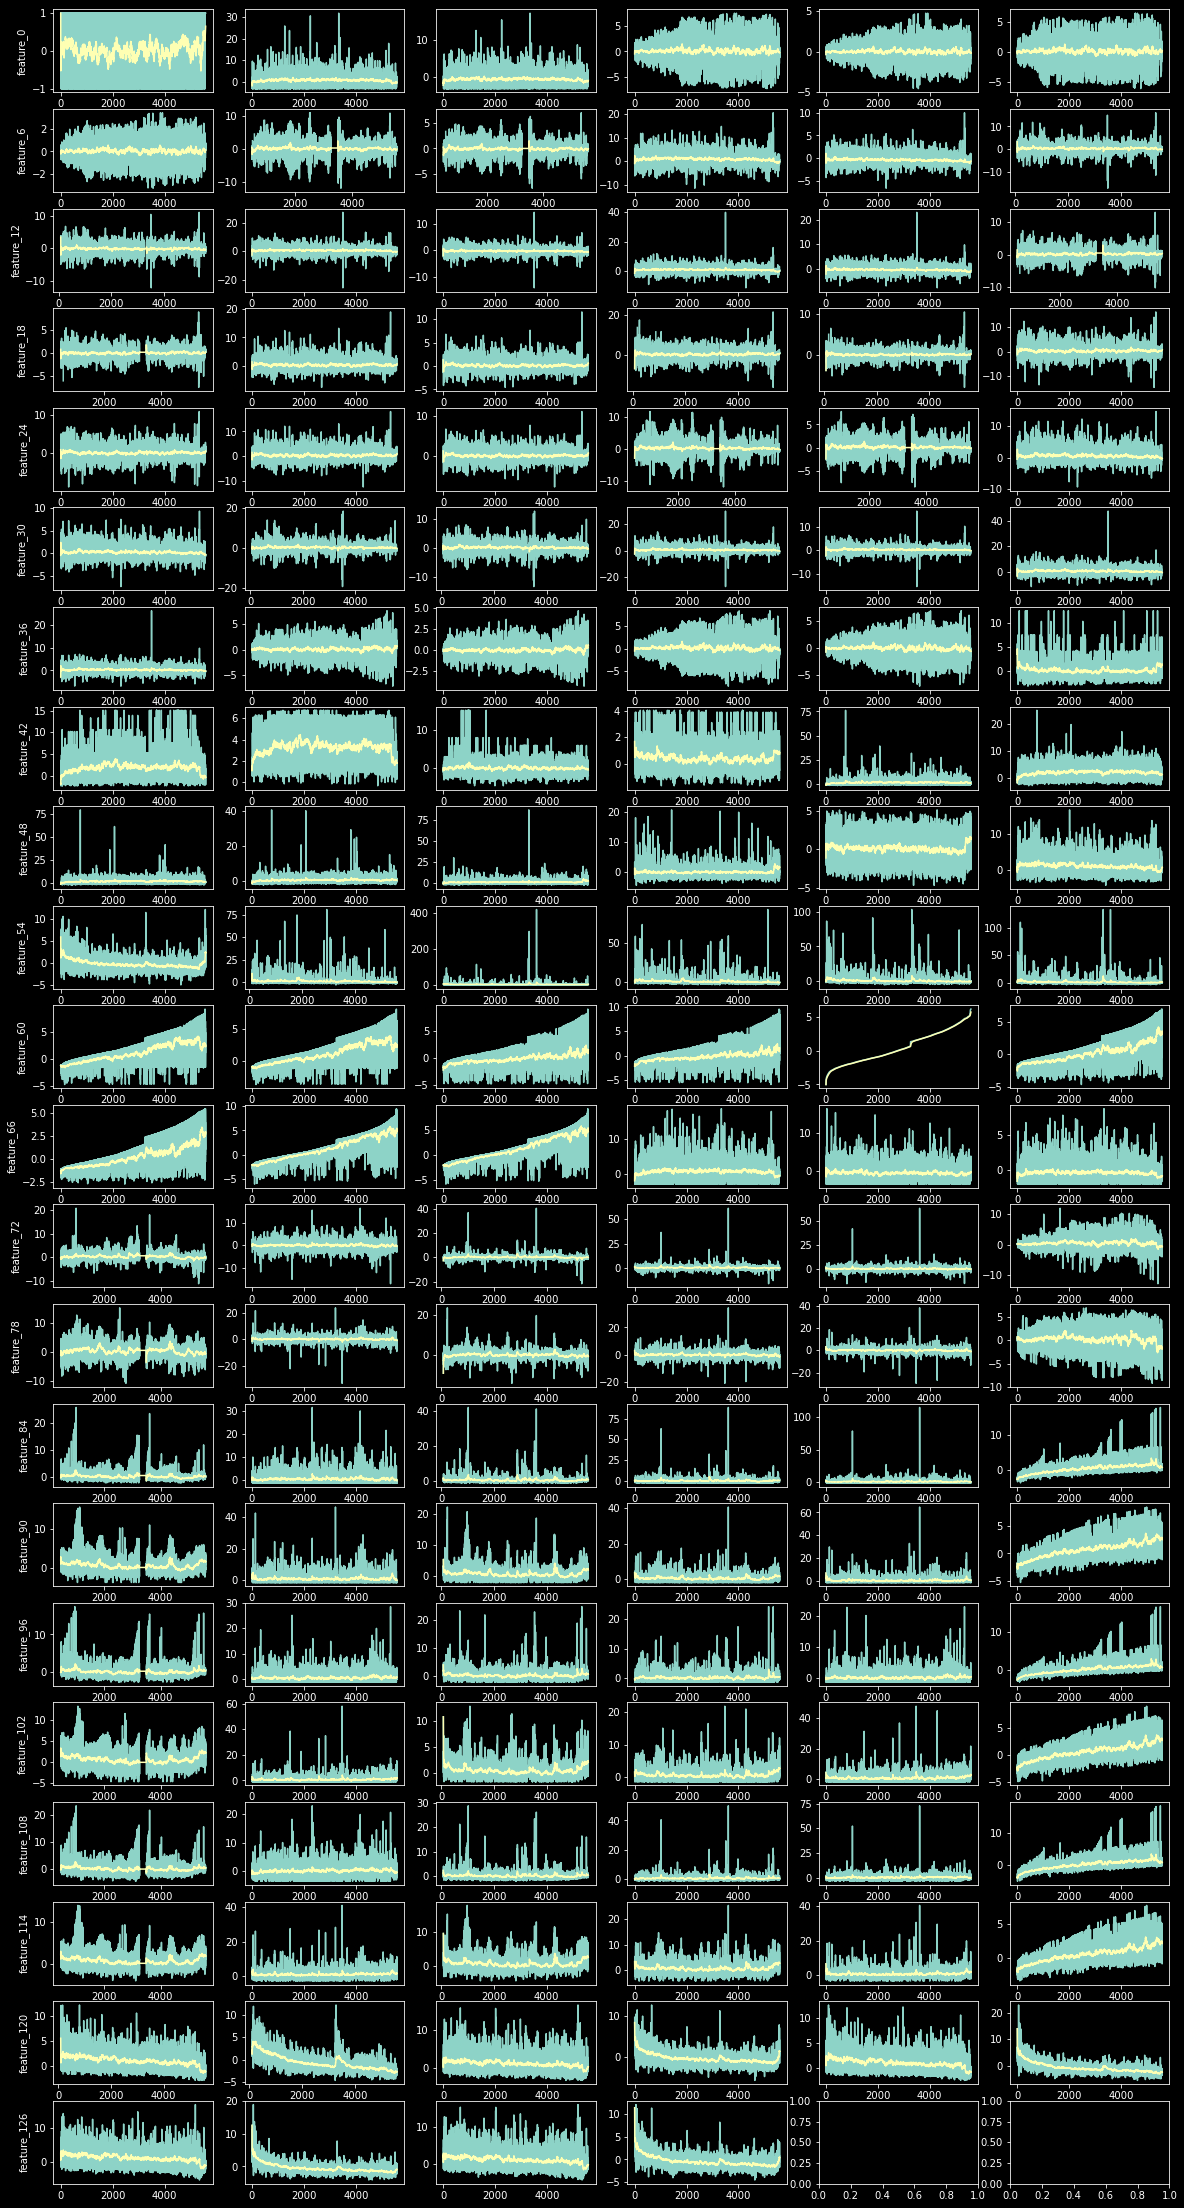

In [35]:
# Overview Time plot (vs. ts_id)
spanSmooth=64
feat_sm=feat.ewm(span=spanSmooth).mean() # smooth version

fig, axs = plt.subplots(nrows=int(nFeat/6)+1, ncols=6,figsize=(20, 40)) # 
for ii,cname in enumerate(feat.columns):
    ax=axs[ii//6,ii%6]
    ax.plot(inD['ts_id'],feat[cname])
    ax.plot(inD['ts_id'],feat_sm[cname])
    if ii%6==0:
        ax.set(ylabel=cname)

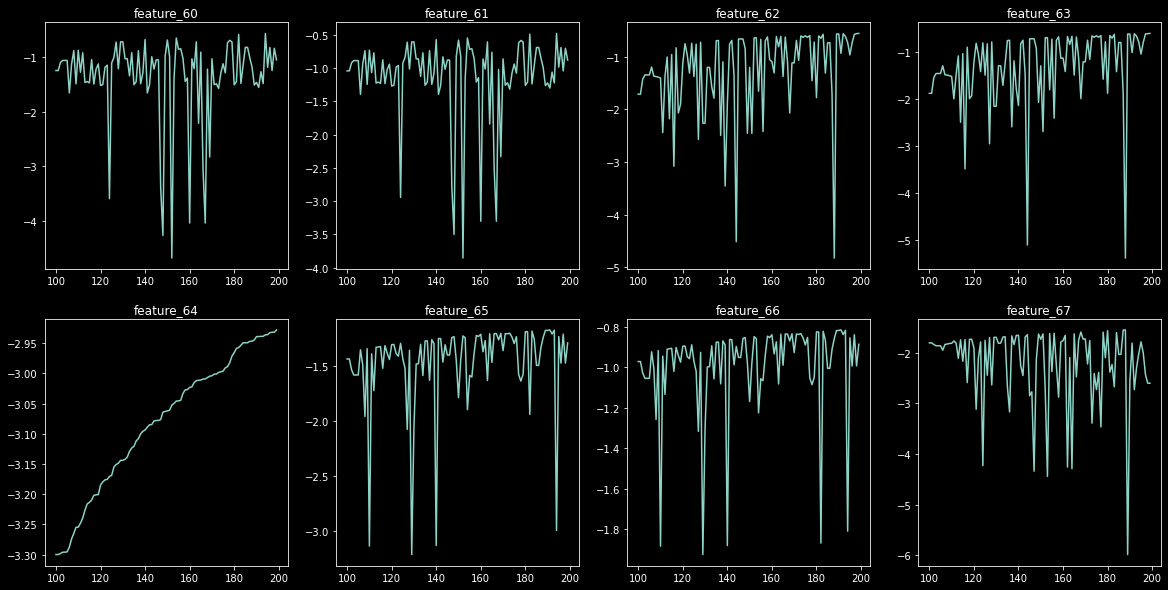

In [47]:
# Closer look at some suspect of level-like features
idxSet=range(100,200)
fig, axs = plt.subplots(nrows=2, ncols=4,figsize=(20, 10)) # 
for ii in range(8):
    cname=feat.columns[ii+60]
    ax=axs[ii//4,ii%4]
    ax.plot(inD['ts_id'].iloc[idxSet],feat[cname].iloc[idxSet])
    ax.set(title=cname)

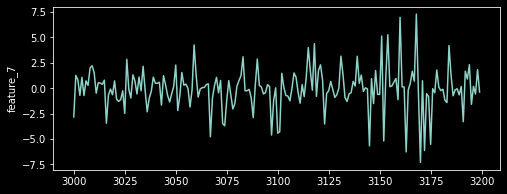

In [61]:
# Individual features
idxSet=range(3000,3200)
cname='feature_7'
_, ax = plt.subplots(nrows=1, ncols=1,figsize=(8, 3)) # 
ax.plot(inD['ts_id'].iloc[idxSet],feat[cname].iloc[idxSet])
ax.set(ylabel=cname);

### 2.2 Distributions

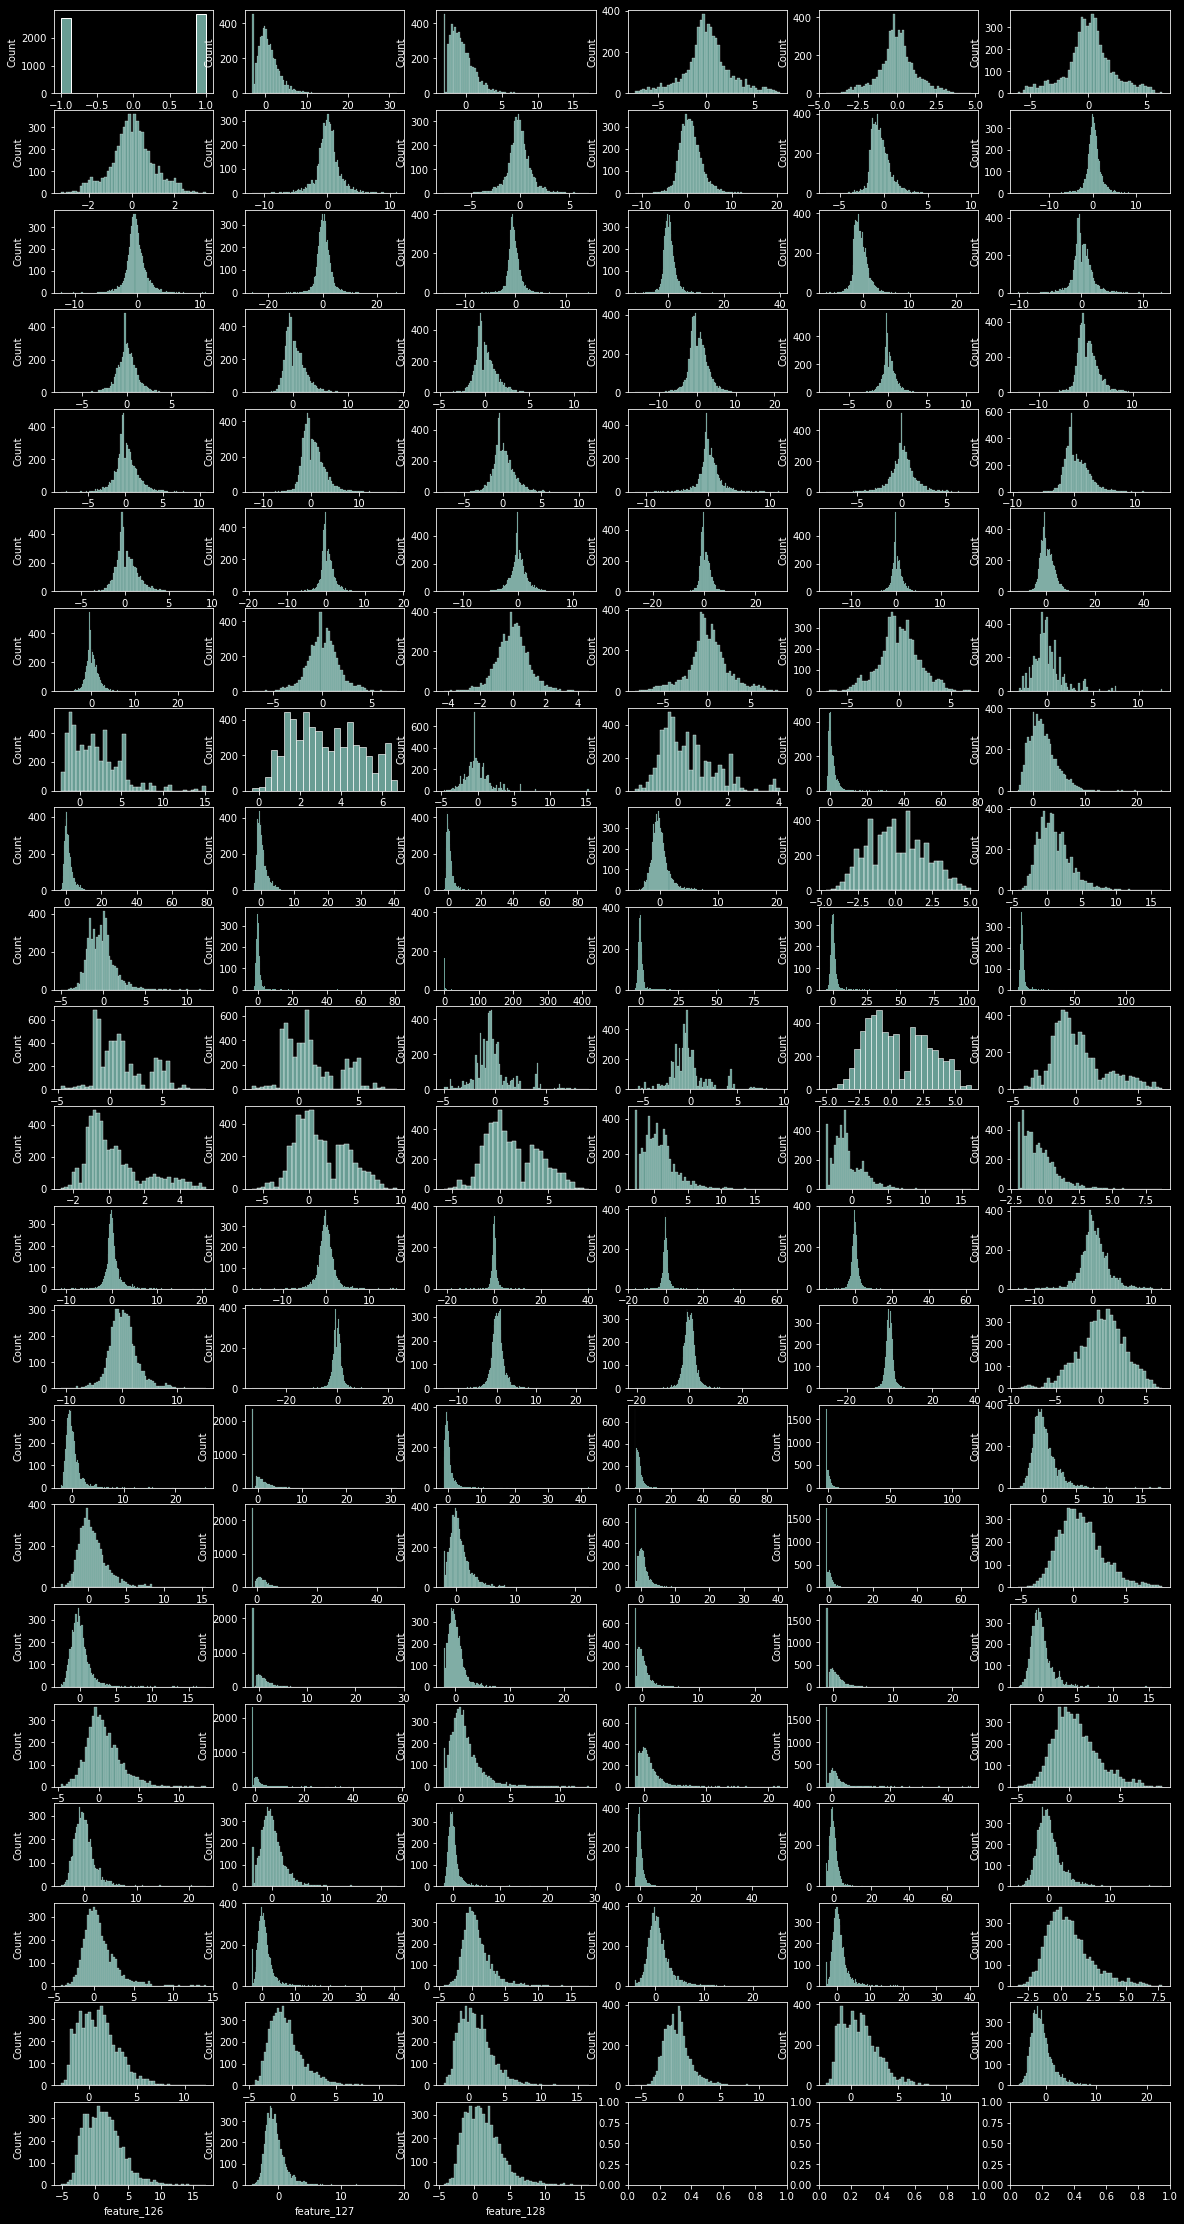

In [24]:

fig, axs = plt.subplots(nrows=int(nFeat/6)+1, ncols=6,figsize=(20, 40)) # 
for ii,cname in enumerate(feat.columns):
    sns.histplot(data=feat[cname],ax=axs[ii//6,ii%6])


## 3. Inter-day characteristics of features:

### 3.1 Features showing diurnal pattern
 - Intr-day trend, e.g., starting at a certain level and goes to another at the end of day
 - Volatility also has intra-day pattern

In [39]:
# Smooth on a random selection of days
daySet=data['date'].unique()
daySet_r=np.random.choice(daySet,size=10)

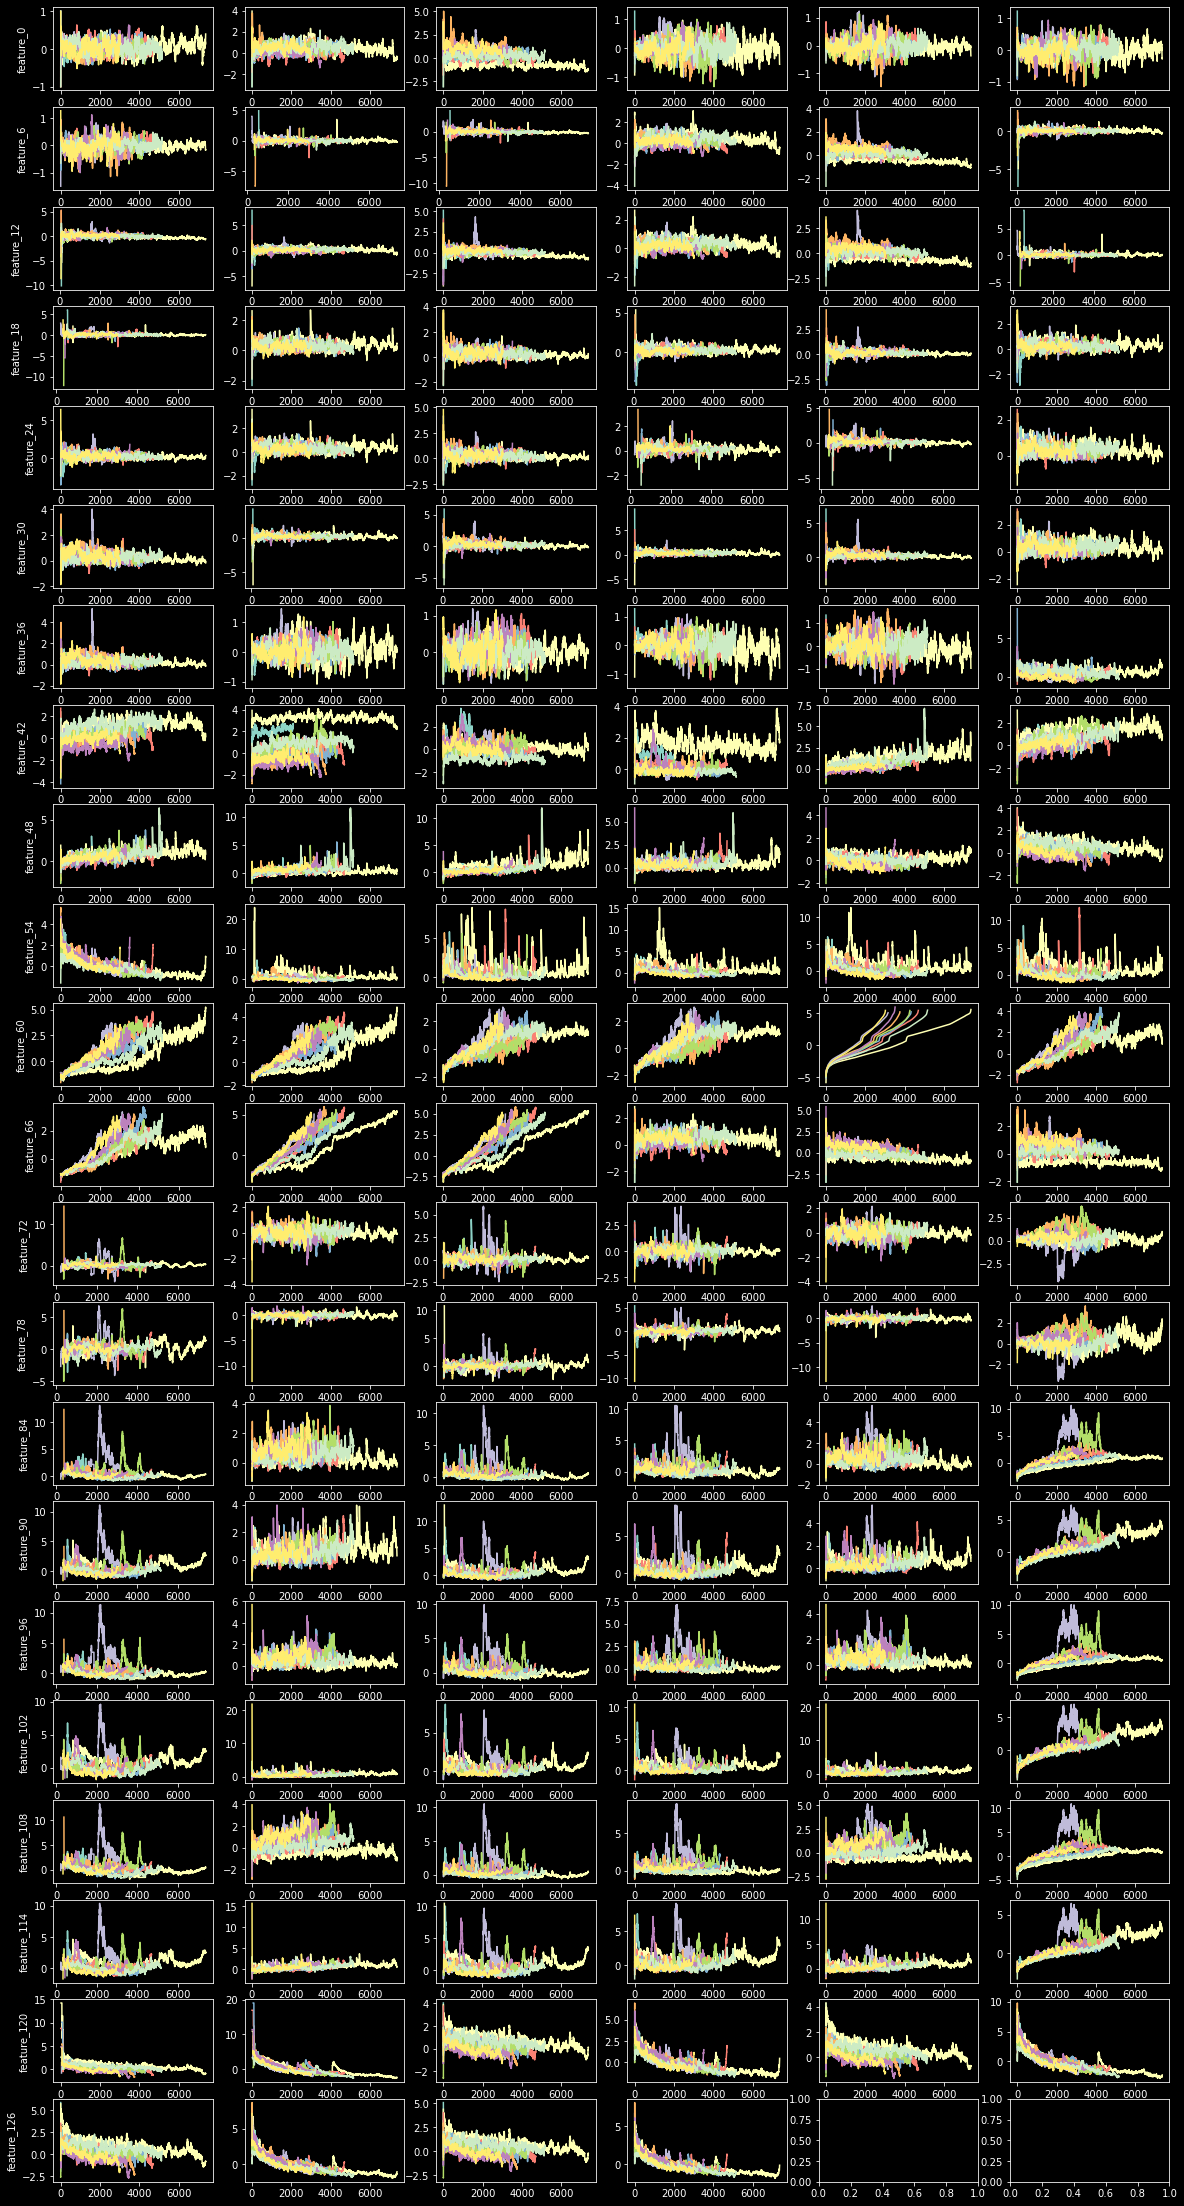

In [46]:
spanSmooth=64
_, axs = plt.subplots(nrows=int(nFeat/6)+1, ncols=6,figsize=(20, 40)) #
for kDay in daySet_r:
    feat_sm=data.loc[data['date']==kDay,featName].ewm(span=spanSmooth).mean()
    for ii,cname in enumerate(featName):
        ax=axs[ii//6,ii%6]
        ax.plot(np.arange(feat_sm.shape[0]),feat_sm[cname].to_numpy())
        if ii%6==0:
            ax.set(ylabel=cname)

### 3.2 Feature beginning values vs. days
Its behavior helps deciding how to fill NaN at the start of days
 - feature_122 and up show some mild trend over days. Most other do not

In [65]:
spanSmooth=8 # Smooth out noise, changing it
featStart=[data.loc[data['date']==kDay,featName].ewm(span=spanSmooth).mean().iloc[spanSmooth,:]
           for kDay in daySet]
featStart=pd.DataFrame(featStart)
featStart.index=daySet

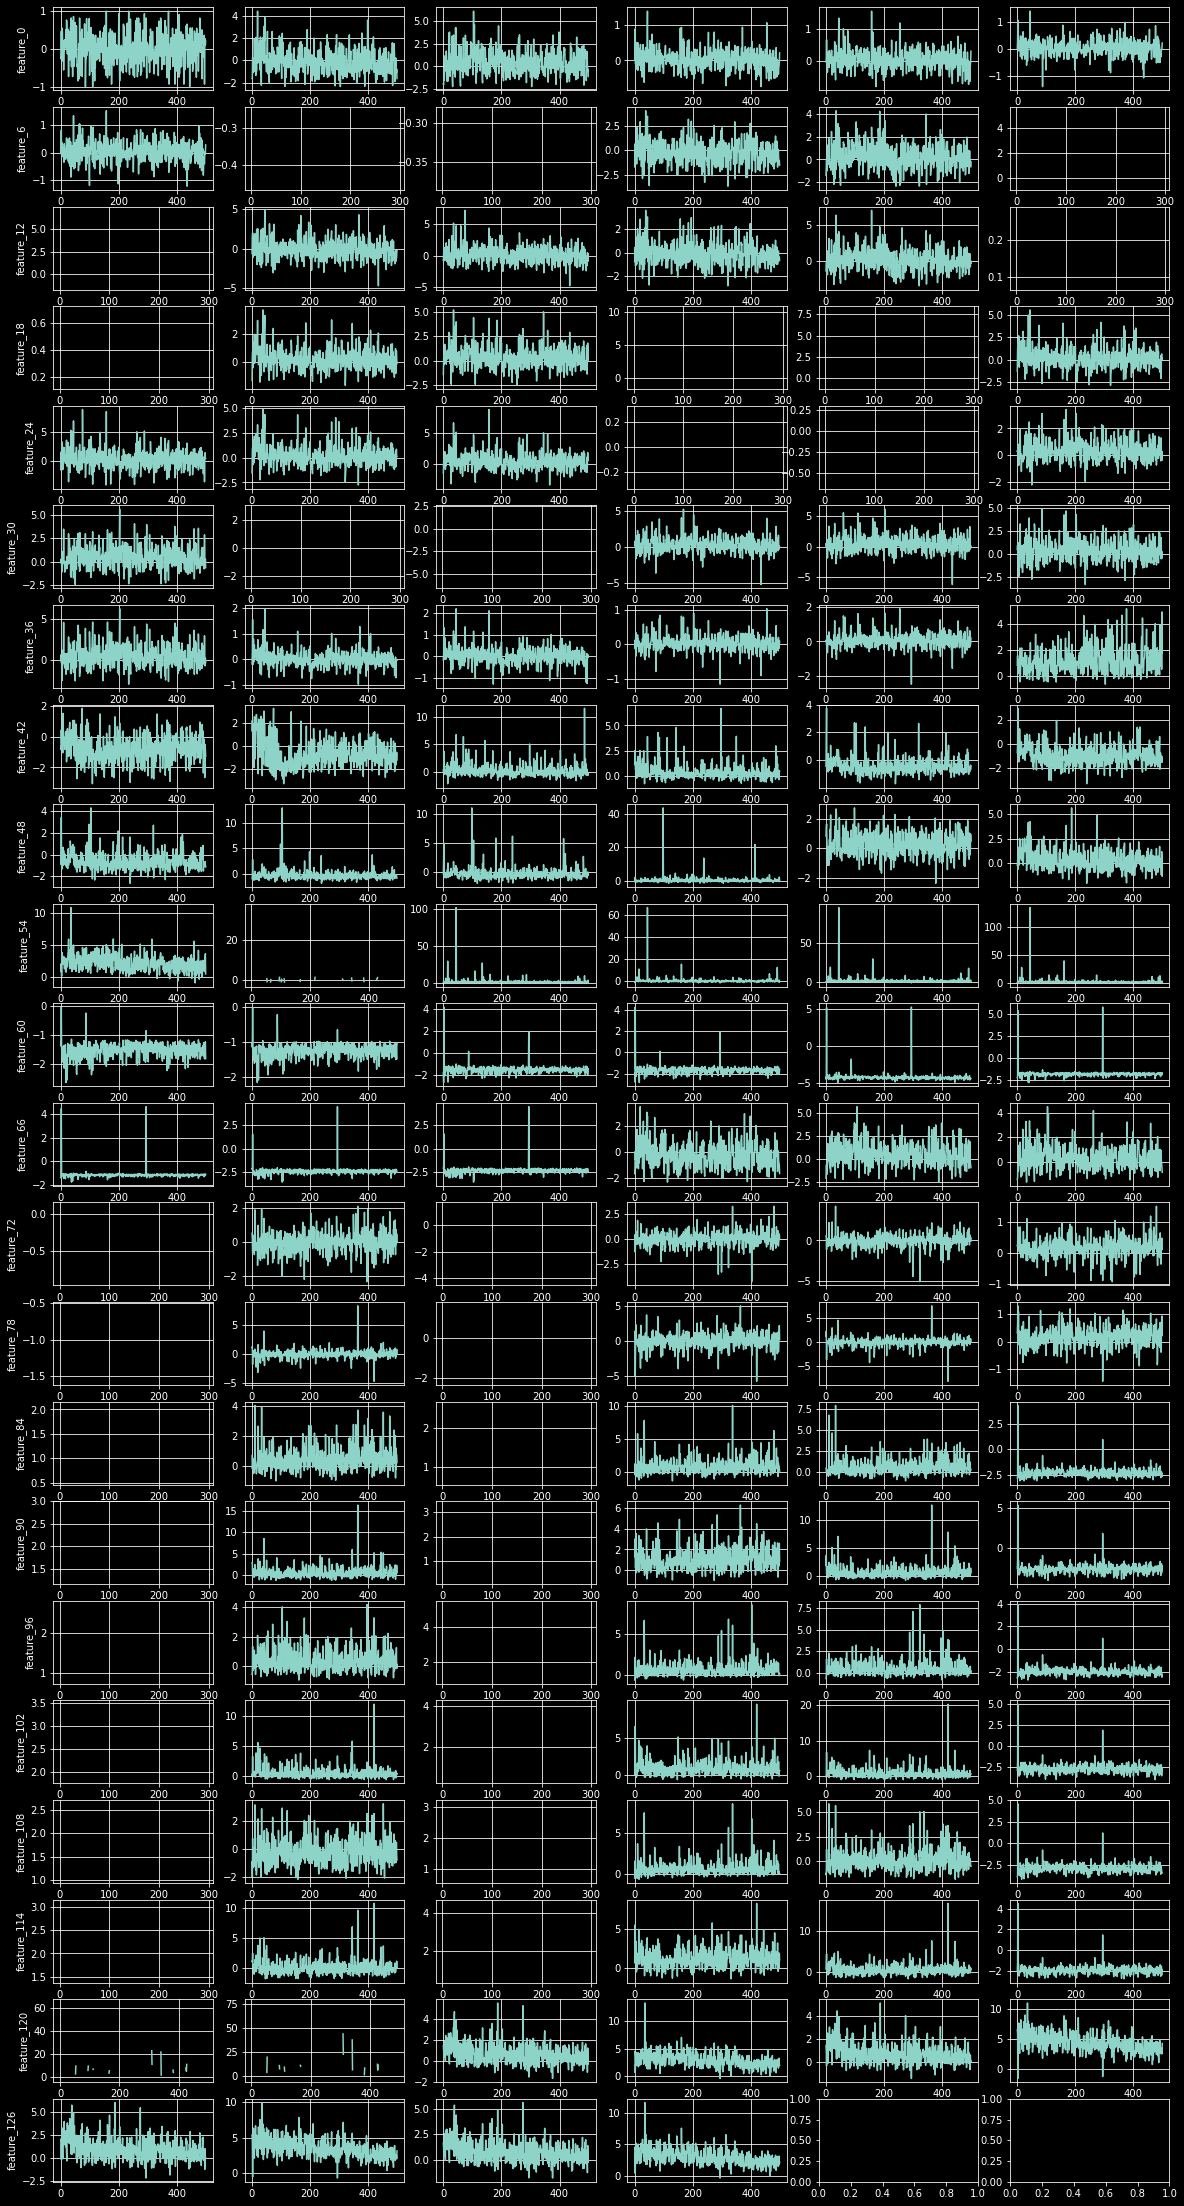

In [70]:
_, axs = plt.subplots(nrows=int(nFeat/6)+1, ncols=6,figsize=(20, 40)) #
for ii,cname in enumerate(featName):
    ax=axs[ii//6,ii%6]
    featStart[cname].plot(ax=ax,grid=True)
    if ii%6==0:
        ax.set(ylabel=cname)